# **1. 그래프의 상태 업데이트**
* HumanMessage : 사용자(사람)의 메시지
* AIMessage : AI(LLM)의 메시지
* AnyMessage : HumanMessage, AIMessage를 포함하는 메시지

In [ ]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.9 MB/s eta 0:00:00


In [ ]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [ ]:
from langchain_core.messages import AIMessage

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}
    # return {"messages": messages + [new_message], "extra_field": 10}

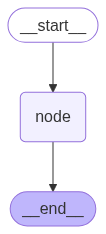

In [ ]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
# set_entry_point : 그래프의 시작 노드를 지정하는 엣지 (START -> "node")
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

graph

In [ ]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("안녕")]})  # invoke: 모든 랭그래프의 워크플로우가 끝날 때 까지 기다렸다가 결과 출력해라.
result

{'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}),
 'extra_field': 10}

In [ ]:
result["messages"]

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})

# **2. 대화메시지 상태 누적 업데이트**

[add_messag](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

In [ ]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # Annotated: 데이터 묶기  # add_messages: 리듀서 함수?
    extra_field: int

In [ ]:
def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}

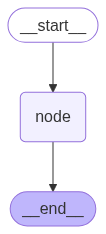

In [ ]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

graph

In [ ]:
input_message = {"role": "user", "content": "안녕하세요."}

result = graph.invoke({"messages": [input_message]})
result

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='65779403-9ae6-4696-a77f-361bf0115d2a'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='fadc7d98-3408-4f27-909f-99a9ea0c2e9f')],
 'extra_field': 10}

In [ ]:
for message in result["messages"]:
# pretty_print()는 데이터나 객체를 보기 좋게(Pretty) 정리해서 출력하는 함수
    message.pretty_print()

================================ Human Message =================================

안녕하세요.
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [ ]:
result["messages"]

[HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='65779403-9ae6-4696-a77f-361bf0115d2a'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='fadc7d98-3408-4f27-909f-99a9ea0c2e9f')]

In [ ]:
 # invoke : 하나의 요청에 대한 결과를 받을 때 까지 코드 실행 멈춤. 한번에 하나의 요청을 처리함
graph.invoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='825dde99-4ce8-42ee-baa2-167e3e69d7f6'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='d6d70652-86fe-431f-aec4-9ed9aa3b26bd')],
 'extra_field': 10}

In [ ]:
# ainvoke : 비동기 처리로 여러 요청을 동시에 보낼 수 있음
await graph.ainvoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='43d91bdc-2cc3-4fca-b692-0479ae4d4027'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='fc47dd39-01bb-462b-b217-d5d4f9365d64')],
 'extra_field': 10}

In [ ]:
# stream : 중간 결과를 실시간으로 반환함
# stream_mode="values" 각 단계의 현재 상태 값 출력
# Default) stream_mode="updates" 각 단계의 상태 업데이트만 출력
# stream_mode="messages" 각 단계의 메시지 출력

for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    print(chunk)
    for state_key, state_value in chunk.items():  # items: key, value를 같이 꺼냄
        if state_key == "messages":
            # print(state_value[-1])
            state_value[-1].pretty_print()  # 맨 마지막 value 꺼내기

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='b95c7659-0828-4e91-bfea-326fe1227377')]}
================================ Human Message =================================

안녕하세요.
{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='b95c7659-0828-4e91-bfea-326fe1227377'), AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='c680fbf8-6ac5-46d7-b53a-79555253751b')], 'extra_field': 10}
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [ ]:
for chunk in graph.stream({"messages": [input_message]}, stream_mode="updates"):  # 업데이트 된 것만 출력
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'node': {'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='357f8500-86a5-4666-989a-7ec6cbac89c4'), 'extra_field': 10}}
node
안녕하세요! 무엇을 도와드릴까요?


In [ ]:
for chunk_msg, metadata in graph.stream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)  # metadata: 여러가지 거쳐온 노드에 의해서 변환된 정보가 담겨있음
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='336ed9bc-80c9-413c-85b0-68939268415a'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node',), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:f8c5357c-7749-06a6-a39d-6a3ad4afc0f6'}
node


In [ ]:
# astream : 비동기 방식으로 스트리밍 처리
async for chunk_msg, metadata in graph.astream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='eeee2f50-39e7-4892-a929-9da3bb8559ea'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node',), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:260c5d97-33c6-3459-6aa1-665639de9582'}
node


# 3. **노드와 엣지 연결**

In [40]:
from typing_extensions import TypedDict

class State(TypedDict):
    value_1: str
    value_2: int

In [41]:
def step_1(state: State):
    return {"value_1": state["value_1"]}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}

In [42]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 엣지 추가
graph_builder.add_edge(START, "step_1") # START ->1
graph_builder.add_edge("step_1", "step_2") # 1-> 2
graph_builder.add_edge("step_2", "step_3") # 2->3

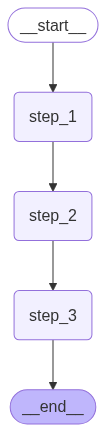

In [43]:
graph = graph_builder.compile()
graph

In [44]:
graph.invoke({"value_1": "apple"})

{'value_1': 'apple b', 'value_2': 10}

# **4. 노드와 엣지를 한번에 연결**

In [45]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'c b', 'value_2': 10}

# **5. 병렬로 연결**
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FbKsmXN%2FbtsQoa6BiQH%2FAAAAAAAAAAAAAAAAAAAAAPpgPBweh6r0kpol4tFqhOR7MdAaIfiH-Lj4HXxoNYBU%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3DdDN3hSsIR6gk3G8930qfsYWKJos%253D'>

In [46]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add] # 업데이트 값이 뒤에 추가되도록 하는 operator.add 리듀서

In [47]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

In [51]:
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

# graph_builder.add_edge(START, "a")
# graph_builder.add_edge("a", "b") # a -> b
# graph_builder.add_edge("b", "c") # b -> c
# graph_builder.add_edge("c", "d") # c -> d
# graph_builder.add_edge("d", END)
# graph = graph_builder.compile()

# graph

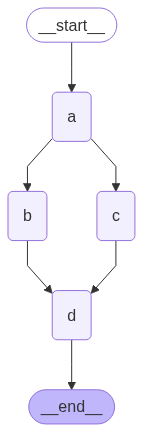

In [52]:
# 엣지 추가
graph_builder.add_edge(START, "a")
graph_builder.add_edge("a", "b") # a -> b
graph_builder.add_edge("a", "c") # a -> c
graph_builder.add_edge("b", "d") # b -> d
graph_builder.add_edge("c", "d") # c -> d
graph_builder.add_edge("d", END)
graph = graph_builder.compile()

graph

In [53]:
graph.invoke({"aggregate":[]})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

# **6. 조건부 엣지 병렬 연결**
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FIHeX1%2FbtsQqoQbMcg%2FAAAAAAAAAAAAAAAAAAAAAI-WYn3hoGJZH0YGGZUAjDY2Xcsn6rtN7Qei9VUmGo2X%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3DiMNBpaepxeJBX4qTGzhFMIrAZfM%253D'>

In [54]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which: str

In [55]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

In [56]:
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)
graph_builder.add_node(e)
graph_builder.add_edge(START, "a")

In [57]:
# bc 혹은 cd 로 라우트를 결정하는 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]

intermediates = ["b", "c", "d"]
graph_builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)

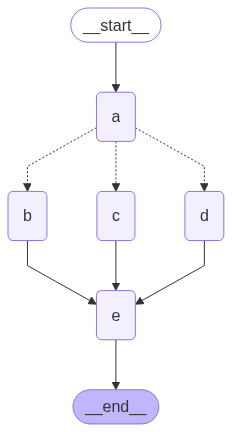

In [58]:
for node in intermediates:
    graph_builder.add_edge(node, "e")

graph_builder.add_edge("e", END)
graph = graph_builder.compile()
graph

In [59]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [61]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

# **7. 조건과 반복**
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FexNpm9%2FbtsQqoil95F%2FAAAAAAAAAAAAAAAAAAAAAIPncRoH-KNiTSy0fHLkuCYoGImVqZSYLqCJFGTP-wrG%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3DM0Jnidnd11rKZG6cxtV0SoDk4YM%253D'>

In [74]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [75]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)

In [76]:
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END

graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "a")
graph = graph_builder.compile()

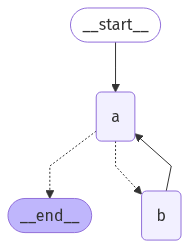

In [77]:
import requests, zlib, base64
from IPython.display import Image

# Mermaid 코드 추출
code = graph.get_graph().draw_mermaid()

# 압축·인코딩 후 Kroki 요청
encoded = base64.urlsafe_b64encode(zlib.compress(code.encode())).decode()
url = f"https://kroki.io/mermaid/png/{encoded}"
resp = requests.get(url)
display(Image(resp.content))

In [78]:
graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

In [79]:
from langgraph.errors import GraphRecursionError
# GraphRecursionError 로 에러를 반환하는 방법
try:
    graph.invoke({"aggregate": []}, config={"recursion_limit": 4})
except GraphRecursionError: # 반복 종료 조건에 도달할 수 없는 경우
    print("Recursion Error")

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Recursion Error



# **8. 조건에 따른 반복 처리하기**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fdrp6dk%2FbtsQoqO213W%2FAAAAAAAAAAAAAAAAAAAAACbLnCZ6cvYoZLtwmeOmdEtVH7cYJLals8GjOOMl45pz%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3Dujyh%252BLlKDcd%252FPmFMhXxzeRauz8o%253D'>

In [69]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [71]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Node D 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["D"]}

graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [72]:
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge(["c", "d"], "a")
graph = graph_builder.compile()

In [73]:
result = graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node C 처리 중 현재 상태값 : ['A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D']
Node B 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A']
Node C 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


# **9. 사용자 입력에 따른 반복 조건 설정**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FW6D61%2FbtsQrJlLxdN%2FAAAAAAAAAAAAAAAAAAAAAP-0lx0tesNGzWsIggu1h7tH9Kp5d3qGQ_yTD39LBiDE%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1759244399%26allow_ip%3D%26allow_referer%3D%26signature%3D%252FP88qFY3SamH0zTcDpDMNIG6LFc%253D'>

In [106]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    human_messages: Annotated[list[HumanMessage], add_messages]
    ai_messages: Annotated[list[AIMessage], add_messages]
    retry_num : int

In [107]:
def chatbot(state:State):
    retry_num = state["retry_num"]
    user_input = input(f"(현재 {retry_num}번째 답변) 사용자 입력: ")
    ai_message = AIMessage(f"{retry_num}번째 답변중!")

    return {"human_messages": [HumanMessage(content=user_input)], "ai_messages": [ai_message]}

def retry(state: State):
    return {"retry_num" : state["retry_num"] + 1}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)  # "chatbot": 노드, chatbot: 콜백
graph_builder.add_node("retry", retry)

In [108]:
def route(state: State) -> Literal["retry", END]:
    if "반복" in state["human_messages"][-1].content:
        return "retry"
    else:
        return END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route)
graph_builder.add_edge("retry", "chatbot")
graph = graph_builder.compile()

In [109]:
for chunk in graph.stream({"human_messages" : "반복", "retry_num": 0}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

(현재 0번째 답변) 사용자 입력: 반복
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='e90d78bb-1d45-4081-8cca-ac78334e7d8e')], 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='daaf5130-ee7a-4faf-8617-ea31f0974684')]}}
chatbot
{'retry': {'retry_num': 1}}
retry
(현재 1번째 답변) 사용자 입력: 반복
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='69fe0c12-8105-4188-bec9-b32007815993')], 'ai_messages': [AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='6462310a-364d-406f-ad0c-c8677da65015')]}}
chatbot
{'retry': {'retry_num': 2}}
retry
(현재 2번째 답변) 사용자 입력: 안녕?
{'chatbot': {'human_messages': [HumanMessage(content='안녕?', additional_kwargs={}, response_metadata={}, id='2f6e386a-5b1d-4aa9-a25d-8381ad77039b')], 'ai_messages': [AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='e5d4abfd-5fa8-4d39-9b6a-f4c03300070

In [110]:
graph.invoke({"human_messages" : "반복", "retry_num": 0})  # 누적된 메시지를 보여줌

(현재 0번째 답변) 사용자 입력: 반복
(현재 1번째 답변) 사용자 입력: 반복
(현재 2번째 답변) 사용자 입력: 반복
(현재 3번째 답변) 사용자 입력: 안녕?


{'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='5151ba42-7bb4-4ba9-8640-d576dd866a5d'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='e17d0f82-694c-4618-804a-39550b889e17'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='74083069-444a-4229-998b-1a41f0550a52'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='1d0bad79-613e-4ae5-bc3c-4ca6174784ee'),
  HumanMessage(content='안녕?', additional_kwargs={}, response_metadata={}, id='8e97286d-cf87-474d-b6da-46a230dc1447')],
 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='a90d3528-d732-4ef1-ac5d-7069ba42dc97'),
  AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='90566882-2a07-4004-9d4f-a758c48dbdf9'),
  AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='d55804d6-a123-4273-b065-580cf092fdb5'),
  AIMessage(content=